check

# Machine Learning in Python - Project 1

Due Friday, Feb 28th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [5]:
url = "https://raw.githubusercontent.com/AwuoeZYC/Project_1/main/"


In [11]:
# Load data in easyshare.csv
d = pd.read_csv(f"{url}adnidata.csv", index_col=0)
d.head()

,RID,ADAS13.bl,ADAS13.m24,AGE,DX.bl,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
1,3,31.00,37.67,81.3,AD,Male,18,Not Hisp/Latino,White,Married,1.0,84599.0,5319.0,1129834.0,1791.0,15506.0,18422.0,1.920691e+06
2,5,14.67,11.00,73.7,CN,Male,16,Not Hisp/Latino,White,Married,0.0,34062.0,7075.0,1116633.0,4433.0,24788.0,21614.0,1.640766e+06
3,6,25.67,22.67,80.4,LMCI,Female,13,Not Hisp/Latino,White,Married,0.0,39826.0,5348.0,927510.0,2277.0,17963.0,17802.0,1.485834e+06
4,7,40.33,47.00,75.4,AD,Male,10,Hisp/Latino,More than one,Married,1.0,25704.0,6729.0,875798.0,2050.0,12063.0,15374.0,1.353519e+06
5,10,24.33,30.33,73.9,AD,Female,12,Not Hisp/Latino,White,Married,1.0,26820.0,5485.0,1033542.0,2676.0,16761.0,19741.0,1.471184e+06


In [8]:
#引用workshop中的代码
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Observed vs Fitted values")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted values vs Residuals")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsq) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Alzheimer's Association, Health Institutes and/or other Charities on dementia and ageing).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [14]:
# Summary of the data structure
#print(d.info())
#print(d.describe())

# Checking for missing values
missing_values = d.isnull().sum()
print("Missing values per column:\n", missing_values)

#重复值检查
# Check duplicate rows
duplicates = d.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicates.sum()

print(f"Number of duplicate rows: {num_duplicates}")

Missing values per column:
 RID              0
ADAS13.bl        0
ADAS13.m24       0
AGE              0
DX.bl            0
PTGENDER         0
PTEDUCAT         0
PTETHCAT         0
PTRACCAT         0
PTMARRY          0
APOE4            5
Ventricles     147
Hippocampus    147
WholeBrain     148
Entorhinal     147
Fusiform       147
MidTemp        147
ICV              8
dtype: int64
Number of duplicate rows: 0


In [15]:
category_columns = ['DX.bl', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4']

stats_table = pd.DataFrame(columns=['Variable', 'Category', 'Count', 'Percentage'])

# 遍历列并计算每个分类变量的值计数
for col in category_columns:
    value_counts = d[col].value_counts().rename_axis('Category').reset_index(name='Count')
    value_counts['Variable'] = col  # 添加变量名称列
    value_counts['Percentage'] = value_counts['Count'] / len(d) * 100  # 计算百分比
    stats_table = pd.concat([stats_table, value_counts[['Variable', 'Category', 'Count', 'Percentage']]], ignore_index=True)

# 调整列顺序
stats_table = stats_table[['Variable', 'Category', 'Count', 'Percentage']]

# 输出表格
print("Statistical table of categorical variables: ")
print(stats_table)

Statistical table of categorical variables: 
    Variable           Category Count  Percentage
0      DX.bl               LMCI   367   35.356455
1      DX.bl                 CN   334   32.177264
2      DX.bl               EMCI   190   18.304432
3      DX.bl                 AD   147   14.161850
4   PTGENDER               Male   582   56.069364
5   PTGENDER             Female   456   43.930636
6   PTETHCAT    Not Hisp/Latino  1011   97.398844
7   PTETHCAT        Hisp/Latino    21    2.023121
8   PTETHCAT            Unknown     6    0.578035
9   PTRACCAT              White   973   93.737958
10  PTRACCAT              Black    35    3.371869
11  PTRACCAT              Asian    16    1.541426
12  PTRACCAT      More than one    10    0.963391
13  PTRACCAT  Am Indian/Alaskan     2    0.192678
14  PTRACCAT            Unknown     1    0.096339
15  PTRACCAT  Hawaiian/Other PI     1    0.096339
16   PTMARRY            Married   798   76.878613
17   PTMARRY            Widowed   120   11.560694
18   

C:\Users\zhang\AppData\Local\Temp\ipykernel_47016\2666474096.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_table = pd.concat([stats_table, value_counts[['Variable', 'Category', 'Count', 'Percentage']]], ignore_index=True)


In [16]:
random_seed = 2

In [23]:
# Define the target and features (we will refine feature selection later)
target = 'ADAS13.m24'
features = d.columns.drop(['RID', 'ADAS13.m24'])  # Exclude person identifier and target(还有第一列的序号)

# Drop rows with missing values (or consider imputation strategies)
d_clean = d.dropna().copy().drop(columns=['RID'])
'''
d_clean = d.copy()
n = list(d_clean.columns)

num_imputer = SimpleImputer(strategy="mean")
d_clean.iloc[:,[11,12,13,14,15,16,17,18]] = num_imputer.fit_transform(d_clean.iloc[:,[11,12,13,14,15,16,17,18]])
'''
# Create normalized volume features
volume_cols = ['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']
for col in volume_cols:
    new_col = col + '_norm'
    d_clean.loc[:, new_col] = d_clean[col] / d_clean['ICV']

# Verify the new columns
print(d_clean[[col for col in d_clean.columns if '_norm' in col]].head())

# Create training and testing sets
train_df, test_df = train_test_split(d_clean, test_size=0.2, random_state=random_seed)
print("Training set size:", train_df.shape)
print("Testing set size:", test_df.shape)

   Ventricles_norm  Hippocampus_norm  WholeBrain_norm  Entorhinal_norm  \
1         0.044046          0.002769         0.588244         0.000932   
2         0.020760          0.004312         0.680556         0.002702   
3         0.026804          0.003599         0.624235         0.001532   
4         0.018990          0.004971         0.647052         0.001515   
5         0.018230          0.003728         0.702524         0.001819   

   Fusiform_norm  MidTemp_norm  
1       0.008073      0.009591  
2       0.015108      0.013173  
3       0.012090      0.011981  
4       0.008912      0.011359  
5       0.011393      0.013418  
Training set size: (708, 23)
Testing set size: (177, 23)


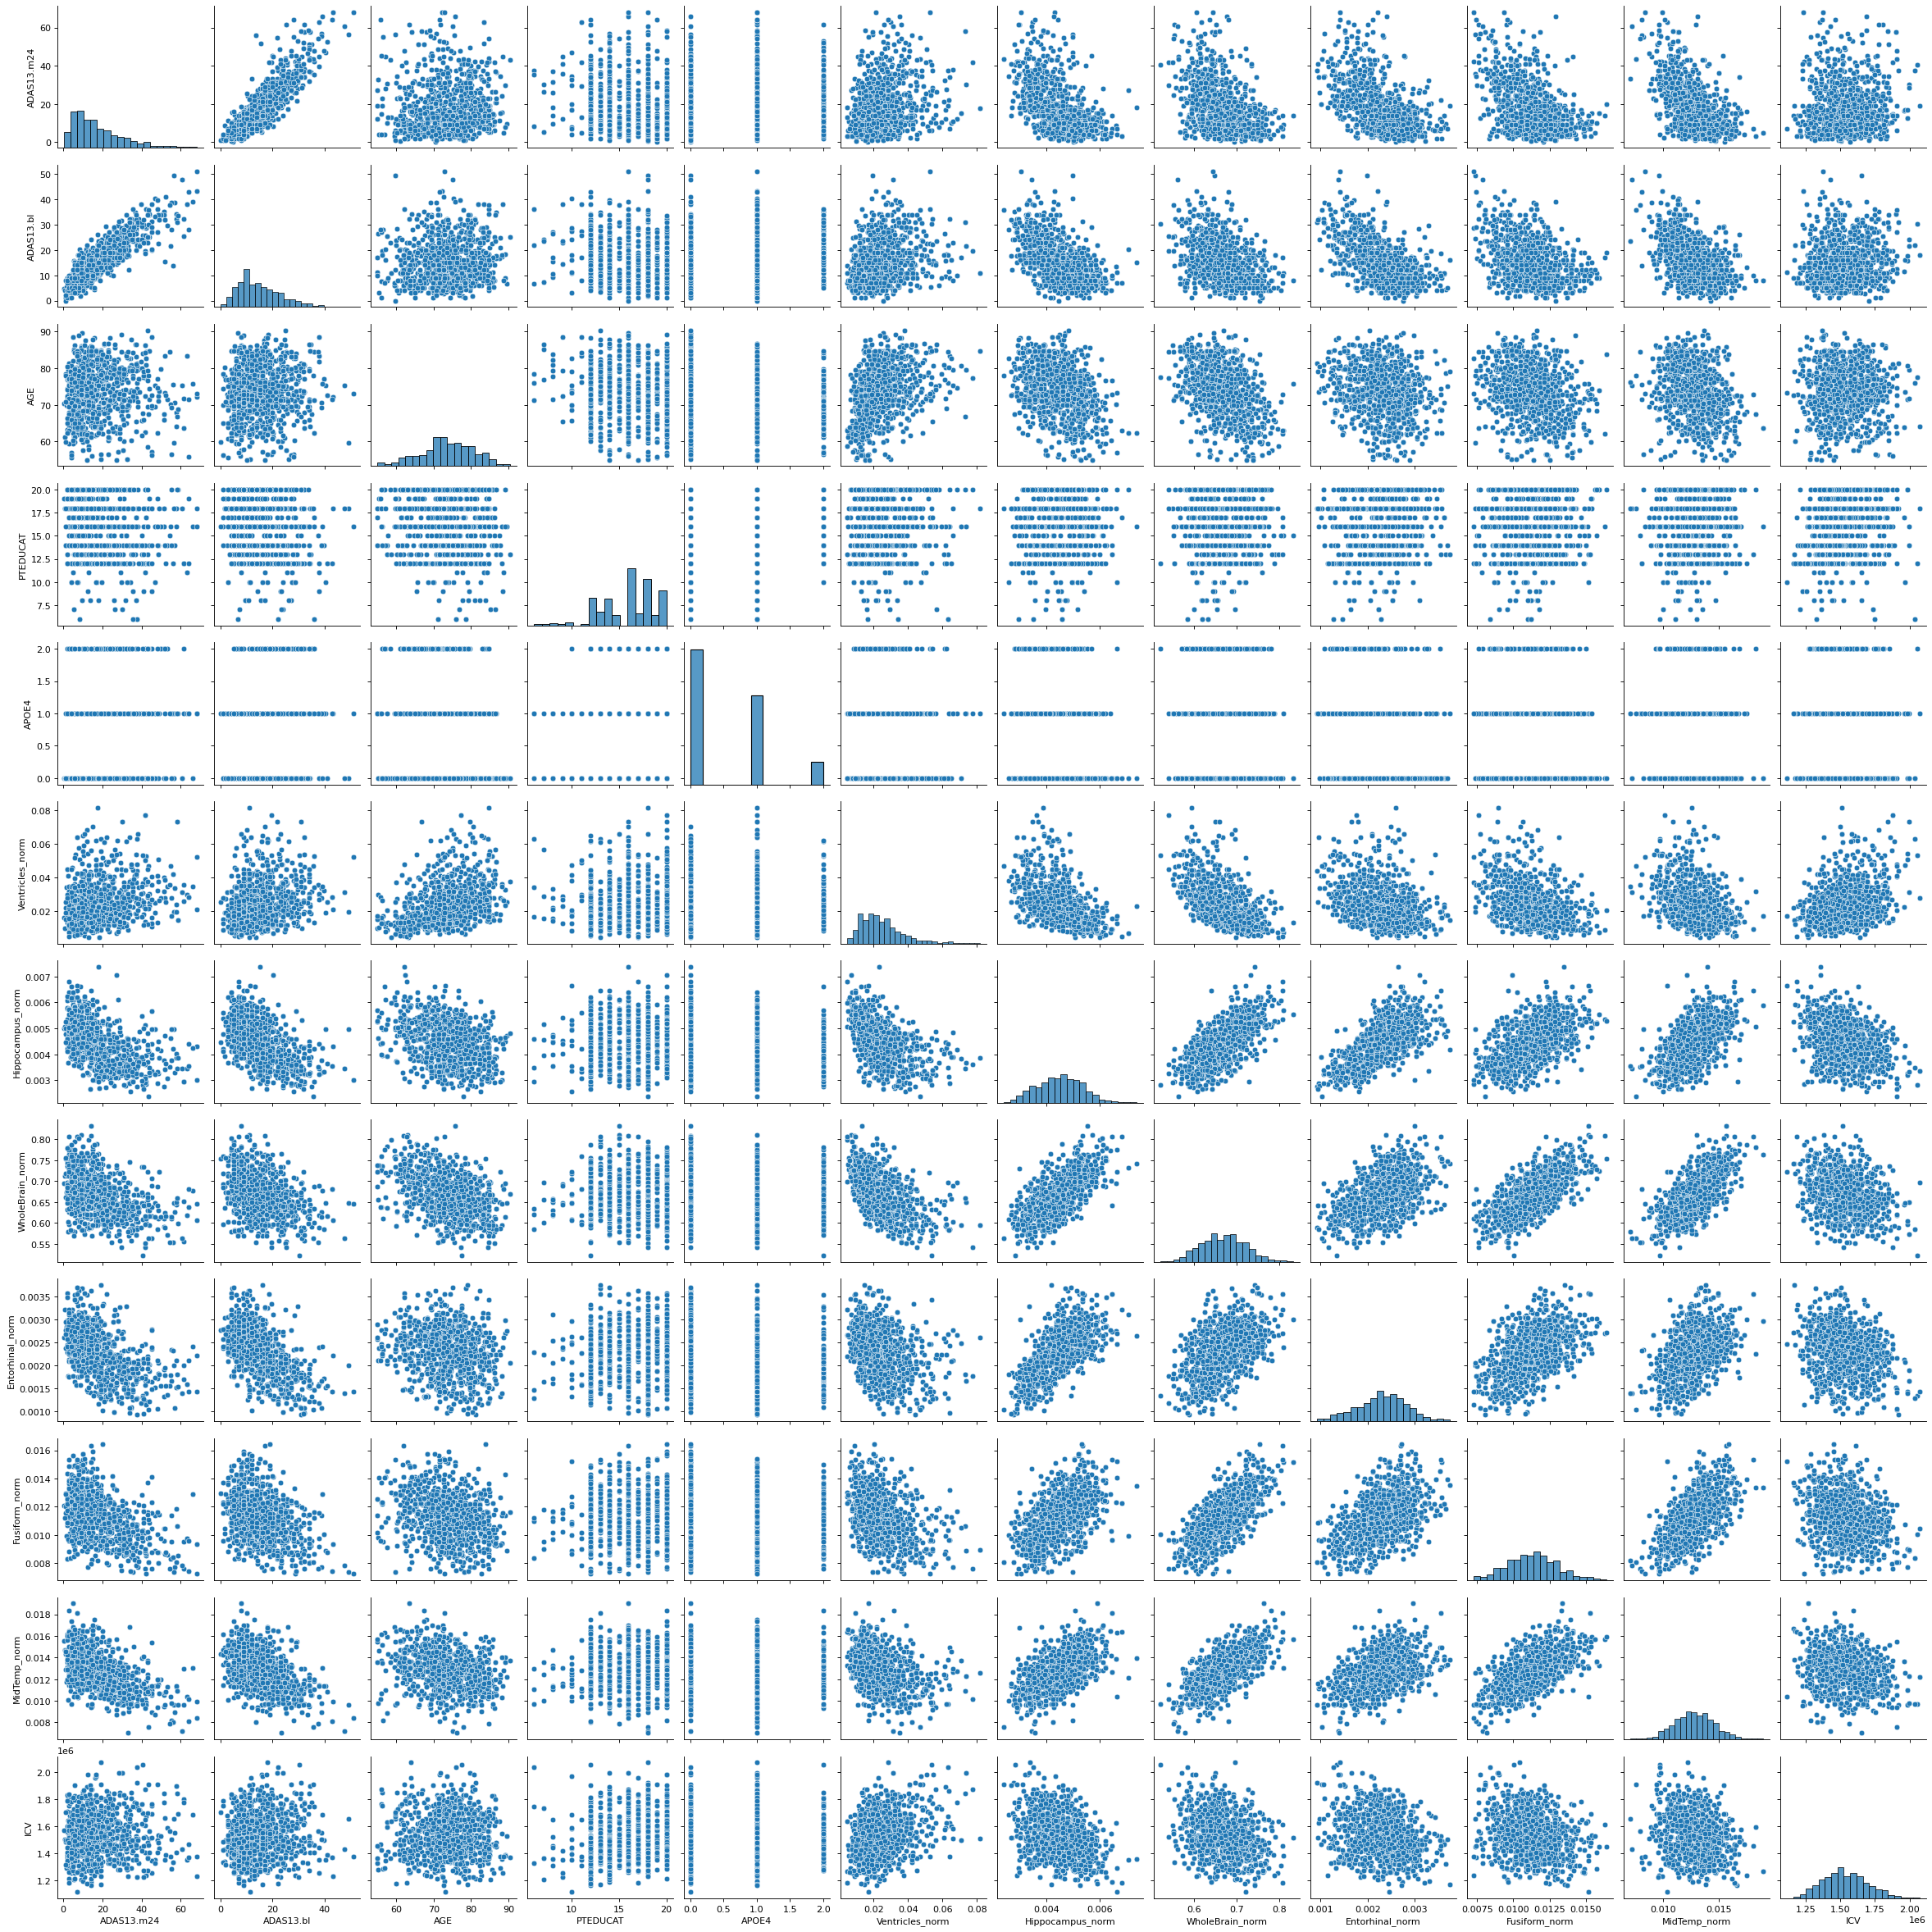

In [20]:
sns.pairplot(d_clean[['ADAS13.m24', 'ADAS13.bl', 'AGE', 'PTEDUCAT', 'APOE4', 'Ventricles_norm', 'Hippocampus_norm', 
                      'WholeBrain_norm', 'Entorhinal_norm', 'Fusiform_norm', 'MidTemp_norm', 'ICV']])
plt.show()

In [ ]:
numeric_df = d_clean.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
print(corr_matrix)

                  ADAS13.bl  ADAS13.m24       AGE  PTEDUCAT     APOE4  \
ADAS13.bl          1.000000    0.876135  0.101363 -0.194897  0.321882   
ADAS13.m24         0.876135    1.000000  0.053998 -0.183624  0.333044   
AGE                0.101363    0.053998  1.000000 -0.095775 -0.144924   
PTEDUCAT          -0.194897   -0.183624 -0.095775  1.000000 -0.064077   
APOE4              0.321882    0.333044 -0.144924 -0.064077  1.000000   
Ventricles         0.250325    0.267249  0.324223  0.032015  0.044348   
Hippocampus       -0.512890   -0.516203 -0.356489  0.132740 -0.237360   
WholeBrain        -0.194202   -0.247259 -0.303661  0.181601 -0.027070   
Entorhinal        -0.529071   -0.515854 -0.177932  0.177687 -0.261776   
Fusiform          -0.326943   -0.404284 -0.245714  0.176065 -0.114523   
MidTemp           -0.366975   -0.442437 -0.220785  0.174468 -0.083289   
ICV                0.086401    0.065261  0.001509  0.148347  0.039333   
Ventricles_norm    0.262255    0.285018  0.365845  

In [ ]:
sns.pairplot(d_clean[['ADAS13.m24', 'ADAS13.bl', 'AGE', 'Hippocampus_norm', 'WholeBrain_norm', 'Entorhinal_norm', 'Fusiform_norm','MidTemp_norm', 'ICV', 
                      'PTGENDER']], hue='PTGENDER')
plt.show()

In [ ]:
sns.pairplot(d_clean[['ADAS13.m24', 'ADAS13.bl', 'AGE', 'Hippocampus_norm', 'WholeBrain_norm', 'Entorhinal_norm', 'Fusiform_norm','MidTemp_norm', 'ICV', 
                      'DX.bl']], hue='DX.bl')
plt.show()

In [ ]:
# Histogram for baseline ADAS-Cog 13 scores
plt.figure()
sns.histplot(d['ADAS13.bl'], bins=20, kde=True)
plt.title('Distribution of Baseline ADAS-Cog 13 Scores')
plt.xlabel('ADAS13.bl')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of baseline vs. 24-month follow-up scores
plt.figure()
sns.scatterplot(x='ADAS13.bl', y='ADAS13.m24', data=d)
plt.title('Baseline vs. 24-Month ADAS-Cog 13 Scores')
plt.xlabel('ADAS13.bl')
plt.ylabel('ADAS13.m24')
plt.show()

# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine, tune, and fit that model. You are strongly encouraged to explore different models (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model with interactions, a polynomial regression, and a lasso model and ultimately settled on the lasso approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail the development of the lasso model in terms of features used and additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline linear regression model on the test data but only briefly describe the baseline model considered*

In [ ]:
# Define a basic set of features for the baseline model
baseline_features = ['ADAS13.bl', 'AGE', 'PTEDUCAT'] + [col for col in d_clean.columns if '_norm' in col]

print(baseline_features)
X_train_baseline = train_df[baseline_features]
y_train = train_df[target]
X_test_baseline = test_df[baseline_features]
y_test = test_df[target]

In [ ]:
# Fit the baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train_baseline, y_train)

# Predict and evaluate
y_pred_baseline = baseline_model.predict(X_test_baseline)
baseline_mse = mean_squared_error(y_test, y_pred_baseline)
print("Baseline Linear Regression MSE:", baseline_mse)

In [ ]:
fe_names = baseline_model.feature_names_in_

coefs = pd.DataFrame(
    np.copy(baseline_model.coef_),
    columns=["Coefficients"],
    index=fe_names,
)

print(coefs)

coefs.plot.barh(figsize=(9, 7))
plt.title("Linear regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)

train_MSE, train_RMSE, train_R2 = model_fit(baseline_model, X_train_baseline, y_train, plot=True)
print(f"Training Data - MSE: {train_MSE}, RMSE: {train_RMSE}, R²: {train_R2}")

test_MSE, test_RMSE, test_R2 = model_fit(baseline_model, X_test_baseline, y_test, plot=True)
print(f"Test Data - MSE: {test_MSE}, RMSE: {test_RMSE}, R²: {test_R2}")

In [ ]:
#考虑性别分类
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

baseline_features_sex = ['PTGENDER', 'ADAS13.bl', 'AGE', 'PTEDUCAT'] + [col for col in d_clean.columns if '_norm' in col]

X_train_baseline_sex = train_df[baseline_features_sex]
y_train = train_df[target]
X_test_baseline_sex = test_df[baseline_features_sex]
y_test = test_df[target]

cat_pre = OneHotEncoder(drop=np.array(['Female']))

pipe_1 = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("cat_pre", cat_pre, [0]), # Applied to sex
        ("num_pre", 'passthrough', [1,2,3,4,5,6,7,8,9])])), 
    ("model", LinearRegression())
])


pipe_1

In [ ]:
# Fit the model
pipe_1.fit(X_train_baseline_sex, y_train)

train_MSE, train_RMSE, train_R2 = model_fit(pipe_1, X_train_baseline_sex, y_train, plot=True)
print(f"Training Data - MSE: {train_MSE}, RMSE: {train_RMSE}, R²: {train_R2}")

test_MSE, test_RMSE, test_R2 = model_fit(pipe_1, X_test_baseline_sex, y_test, plot=True)
print(f"Test Data - MSE: {test_MSE}, RMSE: {test_RMSE}, R²: {test_R2}")


In [ ]:
#Poly(only interaction)
cat_pre = OneHotEncoder(drop=np.array(['Female']))

pf = PolynomialFeatures(interaction_only=True,include_bias=False)

pipe_2 = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("cat_pre", cat_pre, [0]),
        ("num_pre", 'passthrough', [1,2,3,4,5,6,7,8,9])])),
    ("interact", pf),
    ("model", LinearRegression())
])

In [ ]:
# Fit the model
pipe_2.fit(X_train_baseline_sex, y_train)

train_MSE, train_RMSE, train_R2 = model_fit(pipe_2, X_train_baseline_sex, y_train, plot=True)
print(f"Training Data - MSE: {train_MSE}, RMSE: {train_RMSE}, R²: {train_R2}")

test_MSE, test_RMSE, test_R2 = model_fit(pipe_2, X_test_baseline_sex, y_test, plot=True)
print(f"Test Data - MSE: {test_MSE}, RMSE: {test_RMSE}, R²: {test_R2}")

In [ ]:
#Poly
cat_pre = OneHotEncoder(drop=np.array(['Female']))

pf = PolynomialFeatures(include_bias=False)

poly_pipe = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("cat_pre", cat_pre, [0]), 
        ("poly", pf, [1,2,3,4,5,6,7,8,9])])),
    ("model", LinearRegression())])

parameters = {
    'pre_processing__poly__degree': np.arange(1,10,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=random_seed)

grid_search = GridSearchCV(poly_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train_baseline_sex, y_train)

In [ ]:
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

In [ ]:
train_MSE, train_RMSE, train_R2 = model_fit(grid_search, X_train_baseline_sex, y_train, plot=True)
print(f"Test Data - MSE: {test_MSE}, RMSE: {test_RMSE}, R²: {test_R2}")

test_MSE, test_RMSE, test_R2 = model_fit(grid_search, X_test_baseline_sex, y_test, plot=True)
print(f"Test Data - MSE: {test_MSE}, RMSE: {test_RMSE}, R²: {test_R2}")

In [ ]:
degree = np.arange(1,10,1)
fig, ax = plt.subplots(figsize=(9,7), ncols=1, nrows=1)
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='k')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='k', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='r')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='r', label='CV MSE')
ax.legend()
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

In [ ]:
#Ridge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
# Grid of alpha values
alphas = np.logspace(-2, 3, num=300) # from 10^-2 to 10^3

ws = [] # Store coefficients
mses_train = [] # Store training mses
mses_test = [] # Store test mses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Ridge(alpha=a)
    ).fit(X_train_baseline, y_train)
    
    w_temp = np.copy(m[1].coef_)
    ws.append(w_temp) 
    mses_train.append(mean_squared_error(y_train, m.predict(X_train_baseline)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test_baseline)))

# Create a data frame for plotting
sol_path = pd.DataFrame(
    data = ws,
    columns = X_train_baseline.columns # Label columns w/ feature names
).assign(
    alpha = alphas,
).melt(
    id_vars = ('alpha')
)

# Plot solution path of the weights
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path)
ax.set_title("Ridge Coefficients")
plt.show()

In [ ]:
# Grid of tuning parameters
alphas = np.logspace(-3, 2, num=300)  

#Pipeline
m = make_pipeline(
        StandardScaler(),
        Ridge())

# CV strategy
cv = KFold(5, shuffle=True, random_state=random_seed)

# Grid search
gs = GridSearchCV(m,
    param_grid={'ridge__alpha': alphas},
    cv=cv,
    scoring="neg_mean_squared_error")
gs.fit(X_train_baseline, y_train)

In [ ]:
print(gs.best_params_)
print(-gs.best_score_)

In [ ]:
model_fit(gs.best_estimator_, X_test_baseline, y_test, plot=True)

In [ ]:
# Extract only mean and split scores
cv_mse = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
    # Add the alphas as a column
    alpha = alphas
)

cv_mse.update(
    # Convert negative mses to positive
    -1 * cv_mse.filter(regex = '_test_score')
)

# Plot CV MSE
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='alpha', y='mean_test_score', data=cv_mse)
ax.set_ylabel('CV MSE')
plt.show()

In [ ]:
# Reshape the data frame for plotting
d = cv_mse.melt(
    id_vars=('alpha','mean_test_score'),
    var_name='fold',
    value_name='MSE'
)

# Plot the validation scores across folds
plt.figure(figsize=(10,7))
sns.lineplot(x='alpha', y='MSE', color='black', errorbar=None, data = d)  # Plot the mean MSE in black.
sns.lineplot(x='alpha', y='MSE', hue='fold', data = d) # Plot the curves for each fold in different colors
plt.show()

In [ ]:
#Lasso
from sklearn.linear_model import Lasso
alphas = np.linspace(0.01, 1, num=100) #We need smaller values of alpha in the grid

ws = [] # Store coefficients
mses_train = [] # Store training mses
mses_test = [] # Store test mses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Lasso(alpha=a)
    ).fit(X_train_baseline, y_train)
    
    w_temp = np.copy(m[1].coef_)
    ws.append(w_temp) 
    mses_train.append(mean_squared_error(y_train, m.predict(X_train_baseline)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test_baseline)))

# Create a data frame for plotting
sol_path = pd.DataFrame(
    data = ws,
    columns = X_train_baseline.columns # Label columns w/ feature names
).assign(
    alpha = alphas,
).melt(
    id_vars = ('alpha')
)

# Plot solution path of the weights
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path)
ax.set_title("Lasso Coefficients")
plt.show()

In [ ]:
# Grid of tuning parameters
alphas = np.linspace(0.001, 1, num=100)

#Pipeline
m = make_pipeline(
        StandardScaler(),
        Lasso())

# CV strategy
cv = KFold(5, shuffle=True, random_state=random_seed)

# Grid search
gs = GridSearchCV(m,
    param_grid={'lasso__alpha': alphas},
    cv=cv,
    scoring="neg_mean_squared_error")
gs.fit(X_train_baseline, y_train)

print(gs.best_params_)
print(-gs.best_score_)

model_fit(gs.best_estimator_, X_test_baseline, y_test, plot=True)

In [ ]:
cv_mse = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
    # Add the alphas as a column
    alpha = alphas
)

cv_mse.update(
    # Convert negative mses to positive
    -1 * cv_mse.filter(regex = '_test_score')
)
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='alpha', y='mean_test_score', data=cv_mse)
ax.set_ylabel('CV MSE')
plt.show()

d = cv_mse.melt(
    id_vars=('alpha','mean_test_score'),
    var_name='fold',
    value_name='MSE'
)

# Plot the validation scores across folds
plt.figure(figsize=(10,7))
sns.lineplot(x='alpha', y='MSE', color='black', errorbar=None, data = d)  # Plot the mean MSE in black.
sns.lineplot(x='alpha', y='MSE', hue='fold', data = d) # Plot the curves for each fold in different colors
plt.show()

In [ ]:
gs_l = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        LinearRegression()
    ),
    param_grid = {},
    cv=KFold(5, shuffle=True, random_state=random_seed),
    scoring="neg_mean_squared_error"
).fit(X_train_baseline, y_train)

print('CV MSE for baseline linear model', round(gs_l.best_score_ * -1,4))

In [ ]:
from sklearn.linear_model import ElasticNet

# Grid of tuning parameters
alphas = np.linspace(0.001, 10, num=100)
l1r = [0.01, .1, .5, .7, .9, .95, 1]

# CV strategy
cv = KFold(5, shuffle=True, random_state=random_seed)

# Pipeline
m = make_pipeline(
        StandardScaler(),
        ElasticNet())

# Grid search
gs_enet = GridSearchCV(m,
                        param_grid={'elasticnet__alpha': alphas, 'elasticnet__l1_ratio': l1r},
                        cv = cv,
                        scoring="neg_mean_squared_error")
gs_enet.fit(X_train_baseline, y_train)

gs_enet.best_params_

In [ ]:
print('CV MSE for elasticnet model', round(-gs_enet.best_score_,4))
print('CV MSE for ridge model',round(-gs.best_score_,4))

In [ ]:
model_fit(gs_enet.best_estimator_, X_test_baseline, y_test, plot=True)

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a health official or charity director, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on factors that may increase the risk of higher cognitive decline, which may be useful for identiying individuals that may benefit more from any proposed drugs or therapies.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb